In [43]:
import re
import math
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
import sklearn.preprocessing as pp
import sklearn.feature_selection as fs
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from scipy import interp
from metrics import cross_validate
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pylab as plt
from features1 import add_title,fill_age,fill_fare,fill_embarked,fill_cabin,fill_ticket,add_family, simplify_ages_intuition,simplify_ages_bins
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

seed = 252
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total=pd.concat([train,test])

PassengerId=total['PassengerId']

In [44]:
def add_surname(df):
    df['Surname']=df['Name'].apply(lambda x: x.split(",")[0])
    return df
total=add_surname(total)
total=add_title(total)
total=fill_age(total)
total.drop('Name',axis=1,inplace=True)
total=add_family(total)
total=fill_fare(total)
total=fill_embarked(total)
total=fill_cabin(total)
#total=fill_ticket(total)
total=simplify_ages_intuition(total)
FFreq=total['Fare'].value_counts()
TFreq=total['Ticket'].value_counts()
CFreq=total['Cabin'].value_counts()
def add_ffreq(df):
    total['Ffreq']=total['Fare'].apply(lambda x: FFreq[x] if isinstance(x, float) else 0)
    return df
def add_tfreq(df):
    total['Tfreq']=total['Ticket'].apply(lambda x: TFreq[x])
    return df
def add_cfreq(df):
    total['Cfreq']=total['Cabin'].apply(lambda x: 9999 if isinstance(x, float) else CFreq[x])
    return df
total=add_ffreq(total)
total=add_cfreq(total)
total=add_tfreq(total)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Surname        1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 153.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
Passeng

In [45]:
def get_gid(r):
    if r['SibSp']+r['Parch']>0:
        return r['Surname']+" "+ str(r['SibSp']+r['Parch'])
    if r['Tfreq']>1:
        return str(r['Ticket'])
    if r['Cfreq']>1 and r['Cfreq']<12:
        return str(r['Cabin'])
    if r['Ffreq'] and r['Ffreq']<12:
        return str(r['Fare'])
    return "Single"

def add_gid(df):
    df['GID']=df.apply(get_gid,axis=1)
    return df     

def check_minor(r):
    if r['Age']< 14:
        if not r['Pclass']==3:
            return 1
    return 0
def add_minor(df):
    df['Minor']=df.apply(check_minor,axis=1)
    return df


def logl(a):
    a=max(a,0.00001)
    a=min(a,1.0-0.00001)
    return math.log(a/(1-a))

total1 = total.iloc[:891]
survived=total.loc[total1["Survived"]==1,["Pclass","Sex"]]
survived_1 = survived.loc[survived["Pclass"]==1,'Sex']
survived_2 = survived.loc[survived["Pclass"]==2,'Sex']
survived_3 = survived.loc[survived["Pclass"]==3,'Sex']

total_1 = total.loc[total1['Pclass']==1,['Sex','Survived']]
total_2 = total.loc[total1['Pclass']==2,['Sex','Survived']]
total_3 = total.loc[total1['Pclass']==3,['Sex','Survived']]

total_1_m = total_1.loc[total_1['Sex']=='male', 'Survived']
total_1_f = total_1.loc[total_1['Sex']=='female', 'Survived']
total_2_m = total_2.loc[total_2['Sex']=='male', 'Survived']
total_2_f = total_2.loc[total_2['Sex']=='female', 'Survived']
total_3_m = total_3.loc[total_3['Sex']=='male', 'Survived']
total_3_f = total_3.loc[total_3['Sex']=='female', 'Survived']

def get_logl(r):
    x=0
    if r["Pclass"]==1:
        x= survived_1.value_counts()[r['Sex']]
        if r['Sex']=='male':
            x=1.0*x/total_1_m.shape[0]
        else:
            x=1.0*x/total_1_f.shape[0]   
    elif r["Pclass"]==2:
        x= survived_2.value_counts()[r['Sex']]
        if r['Sex']=='male':
            x=1.0*x/total_2_m.shape[0]
        else:
            x=1.0*x/total_2_f.shape[0]
    else:
        x= survived_3.value_counts()[r['Sex']]
        if r['Sex']=='male':
            x=1.0*x/total_3_m.shape[0]
        else:
            x=1.0*x/total_3_f.shape[0]
    return logl(x)
    
def add_logl(df):
    df['SLogL']=0.0
    df.loc[:,('SLogL')]=df.apply(get_logl,axis=1)
    return df

def ticket_stat(ticket):
    if TFreq[ticket]>1:
        a=total.iloc[list(np.where(total['Ticket']==ticket)[0])]['Survived']
        if pd.isnull(a).sum() >0 and a.sum()>1:
            return 3
    return 0

def slogl_1(df):
    df.loc[:,('SLogL')]=df.loc[:,('SLogL')]+df['Ticket'].apply(ticket_stat)
    return df
def slogl_2(df):
    df.loc[:,('SLogL')]=df.loc[:,('SLogL')]+df['GID'].apply(lambda x: -0.5 if x=='Single' else 0)
    return df

def large_group(n):
    if n==7:
        return -3
    if n==8:
        return -1
    if n==11:
        return -3
    return 0

def slogl_3(df):
    df.loc[:,('SLogL')]=df.loc[:,('SLogL')]+df['Tfreq'].apply(large_group)
    return df


In [46]:
total=add_gid(total)
total=add_minor(total)
total=add_logl(total)
total=slogl_1(total)
total=slogl_2(total)
total=slogl_3(total)
total.loc[:,('SLogL')]=total.loc[:,('SLogL')]+total['Minor'].apply(lambda x: 8 if x==1 else 0)

In [42]:
#total = pd.concat([total,pd.get_dummies(total['Title'],prefix='Title')],axis=1)
#total = pd.concat([total,pd.get_dummies(total['Embarked'],prefix='Embarked')],axis=1)
#total = pd.concat([total,pd.get_dummies(total['Cabin'], prefix='Cabin')], axis=1)
#total = pd.concat([total,pd.get_dummies(total['Pclass'], prefix="Pclass")],axis=1)
total = pd.concat([total,pd.get_dummies(total['Age'], prefix="Age")],axis=1)
total['Sex'] = total['Sex'].map({'male':1,'female':0})
total.drop('Title',axis=1,inplace=True)
total.drop('Embarked',axis=1,inplace=True)
total.drop('Cabin', axis=1, inplace=True)
total.drop('Pclass',axis=1,inplace=True)
total.drop('Ticket', inplace=True, axis=1)
total.drop('PassengerId', inplace=True, axis=1)
total.drop('Survived', axis=1, inplace=True)
total.drop('Age',axis=1, inplace=True)

#
total.drop('Surname', axis=1, inplace=True)
total.drop('GID', axis=1, inplace=True)
total.drop('Fare', axis=1, inplace=True)
total.drop('Parch', axis=1, inplace=True)
total.drop('SibSp', axis=1, inplace=True)
total.drop('Singleton', axis=1, inplace=True)
total.drop('Ffreq', axis=1, inplace=True)
total.drop('Tfreq', axis=1, inplace=True)
total.drop('Cfreq', axis=1, inplace=True)
total.drop('FamilySize', axis=1, inplace=True)


In [34]:
total=total[['SLogL']]

In [6]:
total=total[['SLogL','Title_Countess','Title_Master','Title_Miss','Title_Mr','Title_Mrs','Title_Officer','Title_Royalty']]

In [48]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 23 columns):
Age            1309 non-null category
Cabin          1309 non-null int64
Embarked       1309 non-null object
Fare           1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Surname        1309 non-null object
Title          1309 non-null object
FamilySize     1309 non-null int64
Singleton      1309 non-null int64
SmallFamily    1309 non-null int64
LargeFamily    1309 non-null int64
Ffreq          1309 non-null int64
Cfreq          1309 non-null int64
Tfreq          1309 non-null int64
GID            1309 non-null object
Minor          1309 non-null int64
SLogL          1309 non-null float64
dtypes: category(1), float64(3), int64(13), object(6)
memory usage: 236.9+ 

In [36]:
data_y=train['Survived']
data_x=total.iloc[range(len(data_y))]
test_x=total.iloc[len(data_y):]

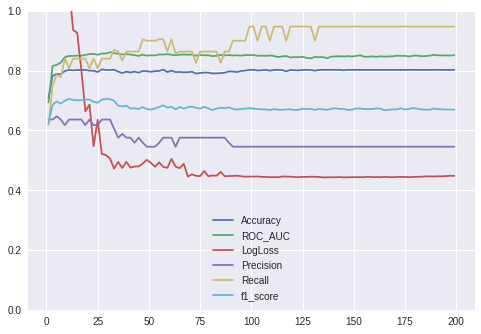

In [37]:
means=[]
rocs=[]
logs=[]
precs=[]
recs=[]
f1s=[]
x=range(1,200,2)
for i in x:
    mean,roc,log,prec,rec,f1=cross_validate(KNeighborsClassifier(i), data_x, data_y,seed=seed, rep=5, cv=10)
    means.append(mean)
    rocs.append(roc)
    logs.append(log)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)

fig, ax = plt.subplots()
ax.set_ylim([0,1])
ax.plot(x, means,label='Accuracy')
ax.plot(x, rocs,label='ROC_AUC')
ax.plot(x, logs,label='LogLoss')
ax.plot(x, precs,label='Precision')
ax.plot(x, recs,label='Recall')
ax.plot(x, f1s,label='f1_score')
legend = ax.legend(loc='lower center', shadow=True)
plt.show()



In [47]:
#32
i=87
means[i], rocs[i], logs[i], precs[i], recs[i], f1s[i]

(0.8024469413233456,
 0.84944804567106369,
 0.44417383959052609,
 0.5454545454545454,
 0.9473684210526315,
 0.66996391696803415)

(0.79866416978776522,
 0.8637091860447107,
 0.44759748923783255,
 0.696969696969697,
 0.7666666666666667,
 0.72038629426882284) SLogL title 87
 
 (0.8000149812734082,
 0.86190636389975273,
 0.44536386083655566,
 0.5151515151515151,
 0.9444444444444444,
 0.66621627003161077) SlogL title 200

In [14]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
SLogL             1309 non-null float64
Title_Countess    1309 non-null uint8
Title_Master      1309 non-null uint8
Title_Miss        1309 non-null uint8
Title_Mr          1309 non-null uint8
Title_Mrs         1309 non-null uint8
Title_Officer     1309 non-null uint8
Title_Royalty     1309 non-null uint8
dtypes: float64(1), uint8(7)
memory usage: 29.4 KB


In [17]:
g = GridSearchCV(KNeighborsClassifier(),{'n_neighbors':range(1,100,1)},cv=10, n_jobs=-1,scoring='f1')
g.fit(data_x,data_y)
g.grid_scores_,g.best_score_,g.best_params_

([mean: 0.69195, std: 0.06941, params: {'n_neighbors': 1},
  mean: 0.66342, std: 0.08858, params: {'n_neighbors': 2},
  mean: 0.69652, std: 0.07072, params: {'n_neighbors': 3},
  mean: 0.68313, std: 0.10381, params: {'n_neighbors': 4},
  mean: 0.72233, std: 0.07827, params: {'n_neighbors': 5},
  mean: 0.70491, std: 0.07835, params: {'n_neighbors': 6},
  mean: 0.69000, std: 0.07019, params: {'n_neighbors': 7},
  mean: 0.69780, std: 0.09225, params: {'n_neighbors': 8},
  mean: 0.70840, std: 0.07755, params: {'n_neighbors': 9},
  mean: 0.68691, std: 0.09187, params: {'n_neighbors': 10},
  mean: 0.69481, std: 0.06502, params: {'n_neighbors': 11},
  mean: 0.69377, std: 0.09099, params: {'n_neighbors': 12},
  mean: 0.69190, std: 0.07219, params: {'n_neighbors': 13},
  mean: 0.70149, std: 0.08307, params: {'n_neighbors': 14},
  mean: 0.71593, std: 0.07956, params: {'n_neighbors': 15},
  mean: 0.71530, std: 0.07638, params: {'n_neighbors': 16},
  mean: 0.71875, std: 0.08231, params: {'n_neighb

In [50]:
test_predictions

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0,

In [26]:

model = KNeighborsClassifier(200)
model.fit(data_x,data_y)
test_predictions = model.predict(test_x)
submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                            'Survived': test_predictions })
submission.to_csv("submission_knn_200_SLogL_Title.csv", index=False)